# Exploring our spectral data 

> This is a preliminary notebook to investigate the spectral data and soon the photos. Not yet clear how to incorporate in our documentation. 

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/data/inktime-data/Xeno-CAL06-and-CAL08')
os.listdir()

['Process_CAL06-08.ipynb',
 'Xenotest_CAL08_SP.csv',
 'Xenotest_CAL08_dE.csv',
 'Xenotest_CAL06_SP.csv',
 'Xenotest_CAL06_dE.csv',
 '.ipynb_checkpoints']

## Reading the csv data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

In [ ]:
d6 = SpectralData('Xenotest_CAL06_SP.csv')

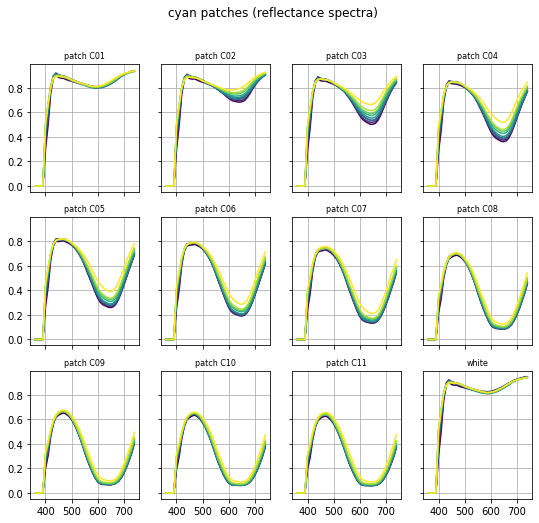

In [ ]:
d6.plot_patches_spectra('cyan')

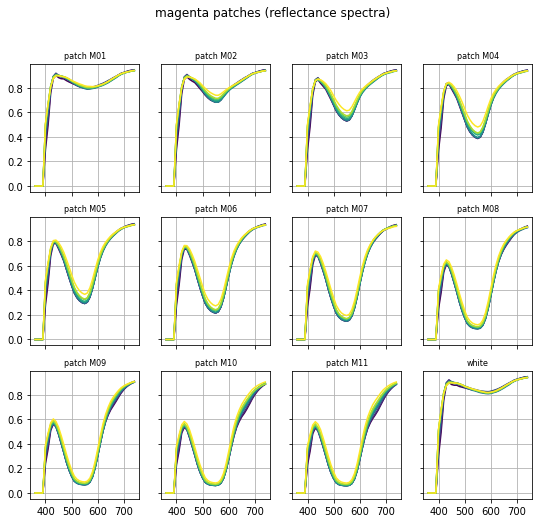

In [ ]:
d6.plot_patches_spectra('magenta')

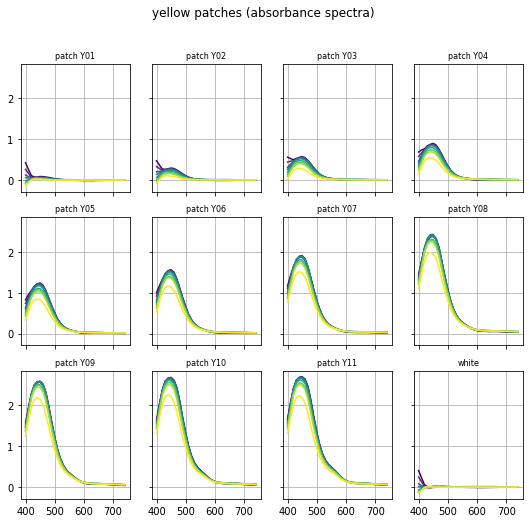

In [ ]:
d6.plot_patches_spectra('yellow', absorbance=True)

In [ ]:
patchset, exposure, trajectories = d6.get_trajectories('yellow')

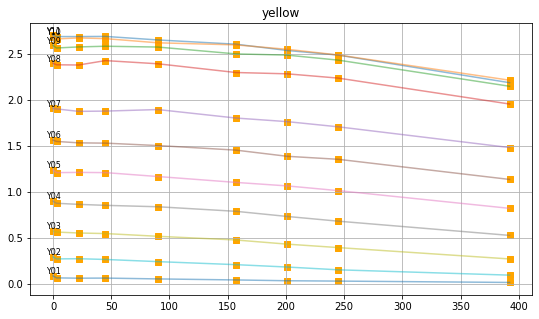

In [ ]:
d6.trajectory_plot('yellow')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import scipy.interpolate as sip 

class SpectralData(): 
    '''Read spectral data.'''
    
    def __init__(self, csv_filename): 
        '''Read spectral data from `csv_filename. '''
        
        df = pd.read_csv(csv_filename)
        
        arr = df.values

        self.cum_hrs = arr[0, 1:].astype(int)
        self.hues = arr[1, 1:]
        self.patches = arr[2, 1:]
        self.spectra = arr[4:, 1:].T.astype(float)
        self.wavelengths = arr[4:,0].astype(float) 

        # CALCULATE ABSORBANCE SPECTRA (CUT-OFF BELOW 400 nm)
    
        # need white reflectance for normalization 
        is_white = self.hues == 'white'
        white_spectra = self.spectra[is_white]
        average_white = np.average(white_spectra, axis=0)

        # cut-off at 400nm to avoid division by zero 
        is_gt400 = self.wavelengths >= 400 
        self.abs_wavelengths = self.wavelengths[is_gt400]

        self.abs_spectra = -np.log(self.spectra[:, is_gt400] / average_white[is_gt400])
        

        
    def plot_patches_spectra(self, hue, absorbance=False): 
        
        
        if absorbance is True: 
            suptitle = 'patches (absorbance spectra)' 
            wavelengths = self.abs_wavelengths 
            spectra = self.abs_spectra 
            
        if absorbance is False: 
            suptitle = 'patches (reflectance spectra)'
            wavelengths = self.wavelengths 
            spectra = self.spectra

            
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=[9, 8], sharex=True, sharey=True)
        axs = axs.flatten()

        is_hue = self.hues == hue
        patchset = sorted(list(set(self.patches[is_hue])))

        for i, p in enumerate(patchset): 

            indices = self.patches == p

            patch_spectra = spectra[indices]

            colors = cm.viridis(np.linspace(0, 1, len(patch_spectra)))

            for j, s in enumerate(patch_spectra): 
                axs[i].set_xticks([400, 500, 600, 700])
                axs[i].plot(wavelengths, s, c=colors[j])
                axs[i].set_title(f'patch {p}', fontsize=8)
                axs[i].grid()

        # also plot white spectra         
        is_white = self.hues == 'white'

        white_spectra = spectra[is_white]

        colors = cm.viridis(np.linspace(0, 1, len(white_spectra)))

        for j, s in enumerate(white_spectra):

            axs[-1].plot(wavelengths, s, c=colors[j])
            axs[-1].set_title(f'white', fontsize=8)
            axs[-1].grid()

        fig.suptitle(f'{hue} {suptitle}')
        
        
    def get_trajectories(self, hue): # , patches=patches, exposure=exposure): 
        '''Returns a sorted array of trajectories'''

        is_hue = self.hues == hue

        patchset = sorted(list(set(self.patches[is_hue])))
        hue_series = []

        for i, p in enumerate(patchset): 

            indices = self.patches == p

            patch_spectra = self.abs_spectra[indices]
            # do I need to check exposure time order? 
            hue_series.append(patch_spectra)

        hue_series = np.array(hue_series)
        
        # locate aborbance maximum for given hue series 
        max_index = np.argwhere(hue_series == hue_series.max()).flatten()[-1]

        trajectories = hue_series[:,:, max_index] 
        
        ## mm assumes 
        indices = np.argsort(np.max(trajectories, axis=1))[::-1]

        exposure = np.array(sorted(list(set(self.cum_hrs))))
        #exposure = np.array(exposure)

        trajectories = trajectories[indices]
        patchset = np.array(patchset)[indices]

        return patchset, exposure, trajectories 

    
    def trajectory_plot(self, hue): 

        patchset, exposure, trajectories = self.get_trajectories(hue)

        fig, ax = plt.subplots(figsize=[9, 5]) 

        # yellow markers have too low contrast 
        if hue is 'yellow': 
            color = 'orange'
        else: 
            color = hue

        for patch, traject in zip(patchset, trajectories): 

            ax.scatter(exposure, traject, c=color, marker='s')
            ax.plot(exposure, traject, alpha=0.5)
            ax.annotate(patch, [exposure[0], traject[0]], fontsize=8, ha='center', va='bottom')
            ax.grid()

        ax.set_title(hue)        

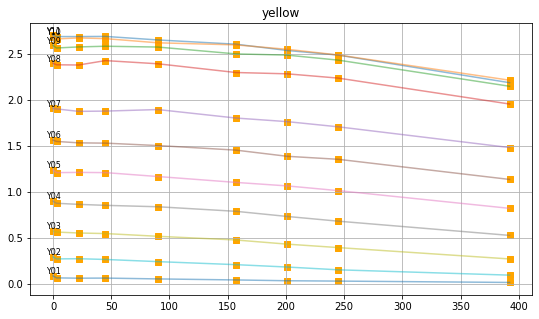

In [ ]:
d6.trajectory_plot('yellow')

In [ ]:
patchset, exposure, trajectories = d6.get_trajectories('yellow')

In [ ]:
od_max = int(trajectories.max() +1) # od_max

In [ ]:
def interpolate(x, y, od_max=od_max):
    '''Interpolate monotonic part of cubic fit.'''
    
    a, b, c = np.polyfit(x, y, 2)
    
    # interpolation to switch x <-> y  
    t_range = np.linspace(x.min(), x.max(), 1000)
    poly = a * t_range**2 + b * t_range + c 
    
    #return t_range, poly 
    
    ipol = sip.interp1d(poly, t_range)
    
    # we need regulary spaced y values 
    od_range = np.linspace(0, od_max, 301)
    is_below_max = (od_range <= c) 
    is_above_min = od_range >= a * x.max()**2 + b * x.max() + c 
    od_range = od_range[is_below_max * is_above_min]
    
    times = ipol(od_range)
    times = times[::-1]
    od_range = od_range[::-1]
    
    return times, od_range 
    

In [ ]:
def timeshift(exposure, trajectories):
     
    # initialize with interpolated top trajectory  
    x0, y0 = interpolate(exposure, trajectories[0])
    trajectory_chain = [[x0, y0]]
    
    for i in range(1, len(trajectories)): 
        
        #print(i)
    
        #x0, y0 = interpolate(exposure, trajectories[i - 1])
        x0, y0 = trajectory_chain[-1]
        x1, y1 = interpolate(exposure, trajectories[i])

        # compute masks  
        mask_0 = np.isin(y0, y1)
        mask_1 = np.isin(y1, y0)

        # ignore if crossing
        if np.any(x0[mask_0] - x1[mask_1] <= 0): 
            pass # skip 
            
        else: 
            # compute timeshift and add 
            # simple time shift 
            if np.sum(mask_0) > 0:
                #print(mask_0)
                dt = x0[mask_0][-1] - x1[mask_1][-1]
                trajectory_chain.append([x1 + dt, y1])
                
            # extrapolate time shift accross gap    
            else: 
                a, b = np.polyfit([x0[-2], x0[-1]], [y0[-2], y0[-1]], 1)
                dt = (y1[0] - b) / a 
                
                trajectory_chain.append([x1 + dt, y1])

        # if non-crossing calculate simple time shift 

        # if non overlapping calculate extrapolated time shift  
    
    return trajectory_chain 

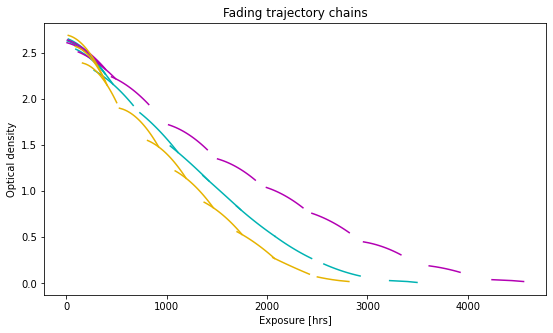

In [ ]:
fig, ax = plt.subplots(figsize=[9, 5])

for hue in ['cyan', 'magenta', 'yellow']: 
    
    patchset, exposure, trajectories = d6.get_trajectories(hue)
    tc = timeshift(exposure, trajectories)
    
    color_dict = {'cyan': [0, 0.7, 0.7], 
                  'magenta': [0.7, 0, 0.7], 
                  'yellow': [0.9, 0.7, 0]}

    for x, y in tc: 
        ax.plot(x, y, c=color_dict[hue], label=hue)
        
plt.title('Fading trajectory chains')
ax.set_xlabel('Exposure [hrs]')
ax.set_ylabel('Optical density');
#ax.legend()
    

Not sure why the yellow trajectories are convex...

In [ ]:
df_06.head(10)

,date_time,unknown,unknown.1,unknown.2,unknown.3,unknown.4,unknown.5,unknown.6,unknown.7,unknown.8,...,unknown.341,unknown.342,unknown.343,unknown.344,unknown.345,unknown.346,unknown.347,unknown.348,unknown.349,unknown.350
0,cum_hrs,0,0,0,0,0,0,0,0,0,...,392,392,392,392,392,392,392,392,392,392
1,colour,cyan,cyan,cyan,cyan,cyan,cyan,cyan,cyan,cyan,...,yellow,yellow,yellow,yellow,white,grey,grey,grey,black,black
2,patch,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,Y08,Y09,Y10,Y11,GS1,GS2,GS3,GS4,GS5,GS6
3,wavelength_nm,,,,,,,,,,...,,,,,,,,,,
4,360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,400,0.2976,0.2944,0.2877,0.2769,0.264,0.252,0.237,0.2146,0.1981,...,0.1504,0.1291,0.1204,0.1206,0.519,0.4217,0.2233,0.0969,0.0791,0.0757
9,410,0.4963,0.4894,0.4718,0.4499,0.4259,0.4006,0.3733,0.3305,0.3035,...,0.1465,0.1227,0.1147,0.1157,0.6785,0.5172,0.2418,0.0917,0.0744,0.0702


I prefer to use numpy for slicing and so on. 

In [ ]:
arr = df_06.values

cum_hrs = arr[0, 1:].astype(int)

hues = arr[1, 1:]

In [ ]:
sorted(list(set(hues)))

['black', 'cyan', 'grey', 'magenta', 'white', 'yellow']

In [ ]:
patches = arr[2, 1:]
patches[0:10] # just show first 10

array(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09',
       'C10'], dtype=object)

In [ ]:
# not sure if I need these 
labels = [f'CAL06_{p}_{h}h' for p, h in zip(patches, cum_hrs)]
labels[0:5]

['CAL06_C01_0h',
 'CAL06_C02_0h',
 'CAL06_C03_0h',
 'CAL06_C04_0h',
 'CAL06_C05_0h']

In [ ]:
is_white = hues == 'white'

In [ ]:
np.array(labels)[is_white]

array(['CAL06_GS1_0h', 'CAL06_GS1_3h', 'CAL06_GS1_22h', 'CAL06_GS1_45h',
       'CAL06_GS1_90h', 'CAL06_GS1_157h', 'CAL06_GS1_201h',
       'CAL06_GS1_245h', 'CAL06_GS1_392h'], dtype='<U14')

In [ ]:
wavelengths = arr[4:,0].astype(float)
wavelengths

array([360., 370., 380., 390., 400., 410., 420., 430., 440., 450., 460.,
       470., 480., 490., 500., 510., 520., 530., 540., 550., 560., 570.,
       580., 590., 600., 610., 620., 630., 640., 650., 660., 670., 680.,
       690., 700., 710., 720., 730., 740.])

In [ ]:
spectra = arr[4:, 1:].T.astype(float)

In [ ]:
is_cyan = hues == 'cyan'

In [ ]:
cyan_patchset = sorted(list(set(patches[is_cyan])))
cyan_patchset

['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11']

In [ ]:
%matplotlib notebook

In [ ]:
def patches_plot(hue, spectra=spectra, wavelengths=wavelengths, absorbance=False): 
    
    suptitle = 'patches (reflectance)'
    
    if absorbance is True: 
        suptitle = 'patches (absorbance)' 
        wavelengths, spectra = absorbance_spectra()
    
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=[9, 8], sharex=True, sharey=True)
    axs = axs.flatten()
    
    is_hue = hues == hue
    patchset = sorted(list(set(patches[is_hue])))

    for i, p in enumerate(patchset): 

        indices = patches == p

        patch_spectra = spectra[indices]

        colors = cm.viridis(np.linspace(0, 1, len(patch_spectra)))

        for j, s in enumerate(patch_spectra): 
            axs[i].set_xticks([400, 500, 600, 700])
            axs[i].plot(wavelengths, s, c=colors[j])
            axs[i].set_title(f'patch {p}', fontsize=8)
            axs[i].grid()

    # plot white spectra         
    is_white = hues == 'white'

    white_spectra = spectra[is_white]

    #fig, ax = plt.subplots(figsize=[9, 5])

    colors = cm.viridis(np.linspace(0, 1, len(white_spectra)))

    for j, s in enumerate(white_spectra):

        axs[-1].plot(wavelengths, s, c=colors[j])
        axs[-1].set_title(f'white', fontsize=8)
        axs[-1].grid()
        
    fig.suptitle(f'{hue} {suptitle}')
    

    def get_trajectories(self, hue): # , patches=patches, exposure=exposure): 
        '''Returns a sorted array of trajectories'''

        is_hue = self.hues == hue

        patchset = sorted(list(set(self.patches[is_hue])))
        hue_series = []

        for i, p in enumerate(patchset): 

            indices = self.patches == p

            patch_spectra = self.abs_spectra[indices]
            # do I need to check exposure time order? 
            hue_series.append(patch_spectra)

        hue_series = np.array(hue_series)
        
        # locate aborbance maximum for given hue series 
        max_index = np.argwhere(patch_series == hue_series.max()).flatten()[-1]

        trajectories = hue_series[:,:, max_index] 
        
        ## mm assumes 
        indices = np.argsort(np.max(trajectories, axis=1))[::-1]

        #exposure = np.array(exposure)

        trajectories = trajectories[indices]
        patchset = np.array(patchset)[indices]

        return patchset, trajectories 

NameError: name 'spectra' is not defined

In [ ]:
def absorbance_spectra(): 
    
    # need white reflectance for normalization 
    is_white = hues == 'white'
    white_spectra = spectra[is_white]
    average_white = np.average(white_spectra, axis=0)
    
    # cut-off at 400nm to avoid division by zero 
    is_gt400 = wavelengths >= 400 
    
    wavelengths_gt400 = wavelengths[is_gt400]
    
    absorbance_spectra = -np.log(spectra[:, is_gt400] / average_white[is_gt400])
    
    return wavelengths_gt400, absorbance_spectra



<IPython.core.display.Javascript object>


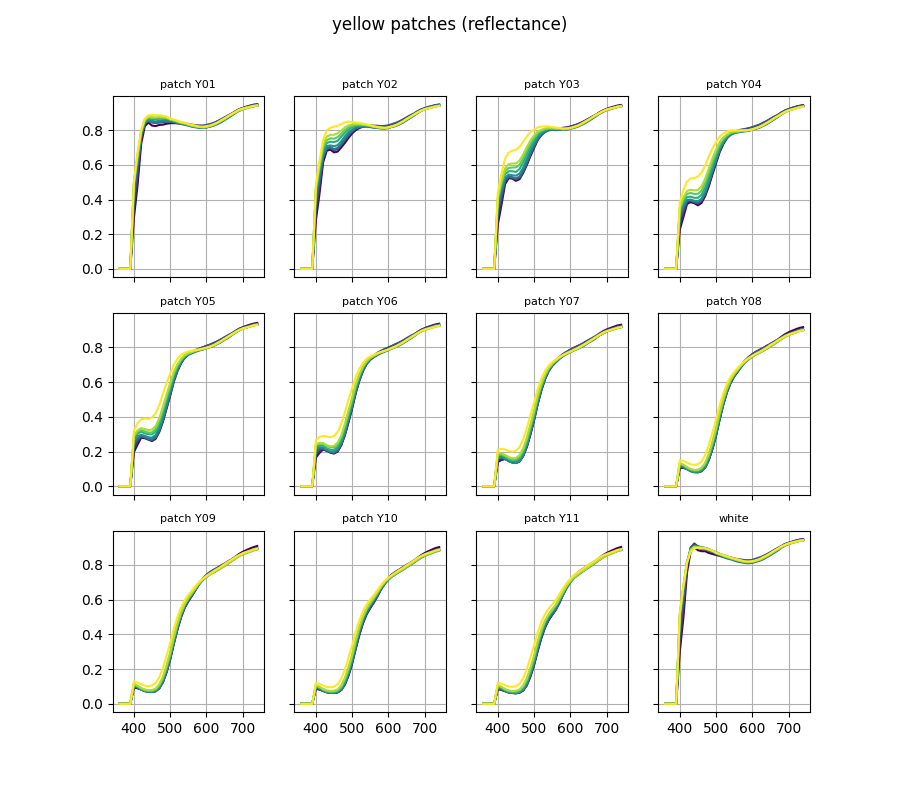

<IPython.core.display.Javascript object>


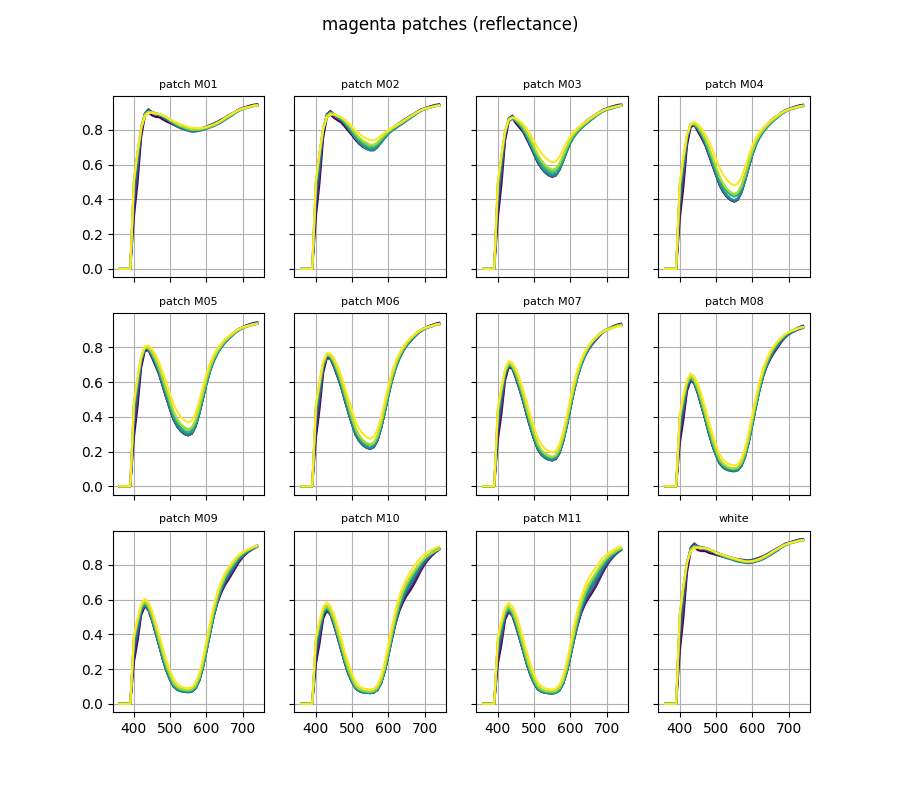

<IPython.core.display.Javascript object>


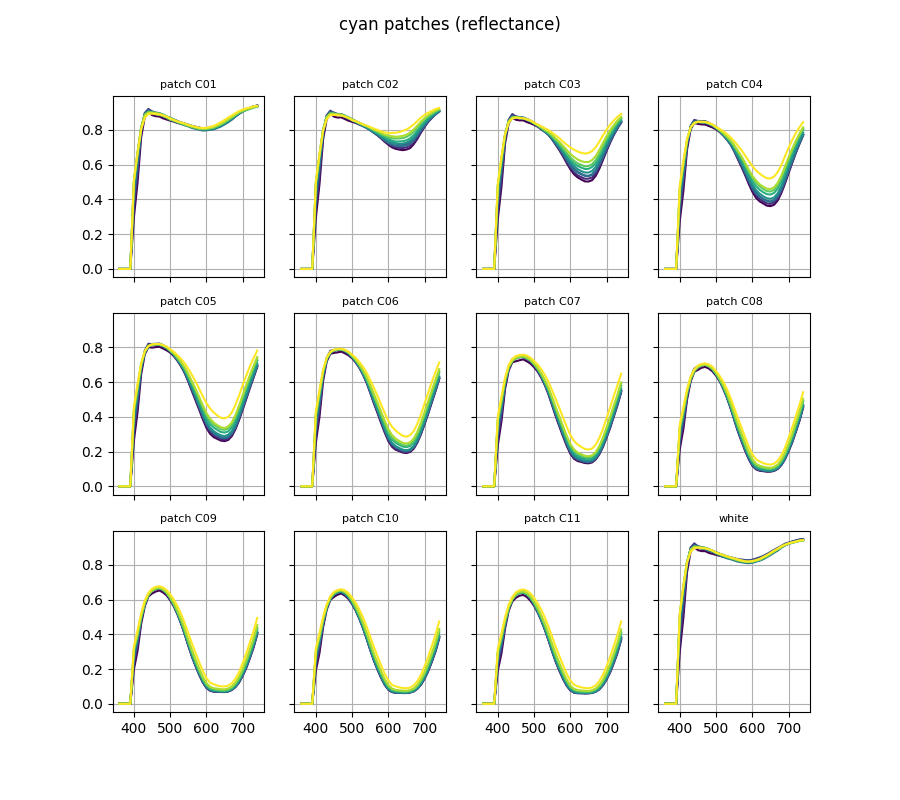

In [ ]:
patches_plot('yellow')
patches_plot('magenta')
patches_plot('cyan')

<IPython.core.display.Javascript object>


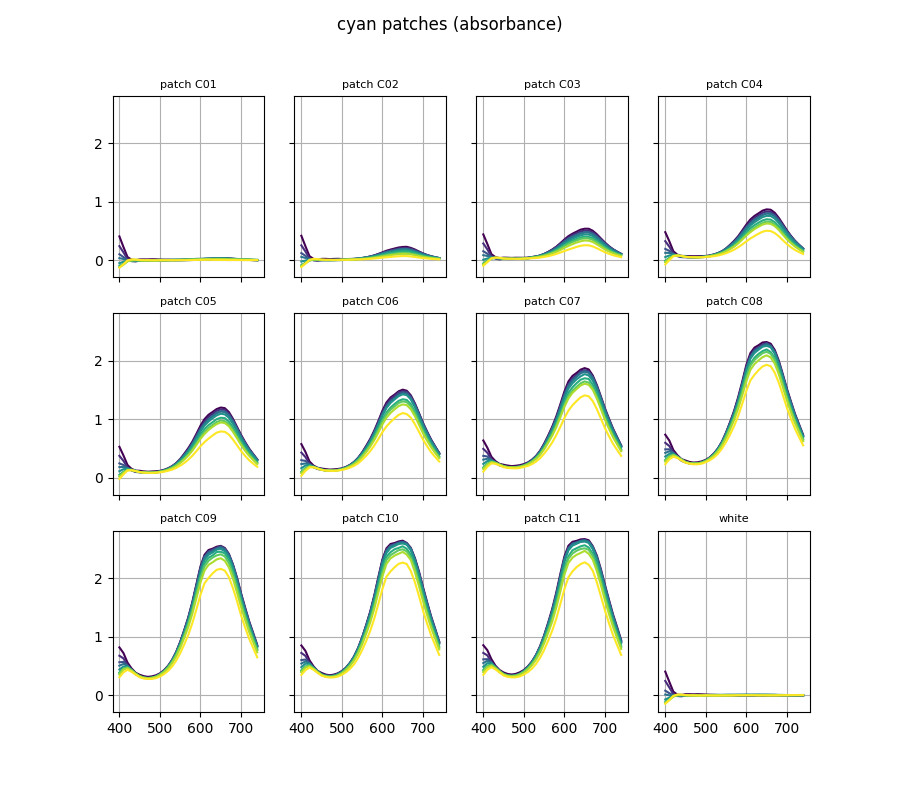

<IPython.core.display.Javascript object>


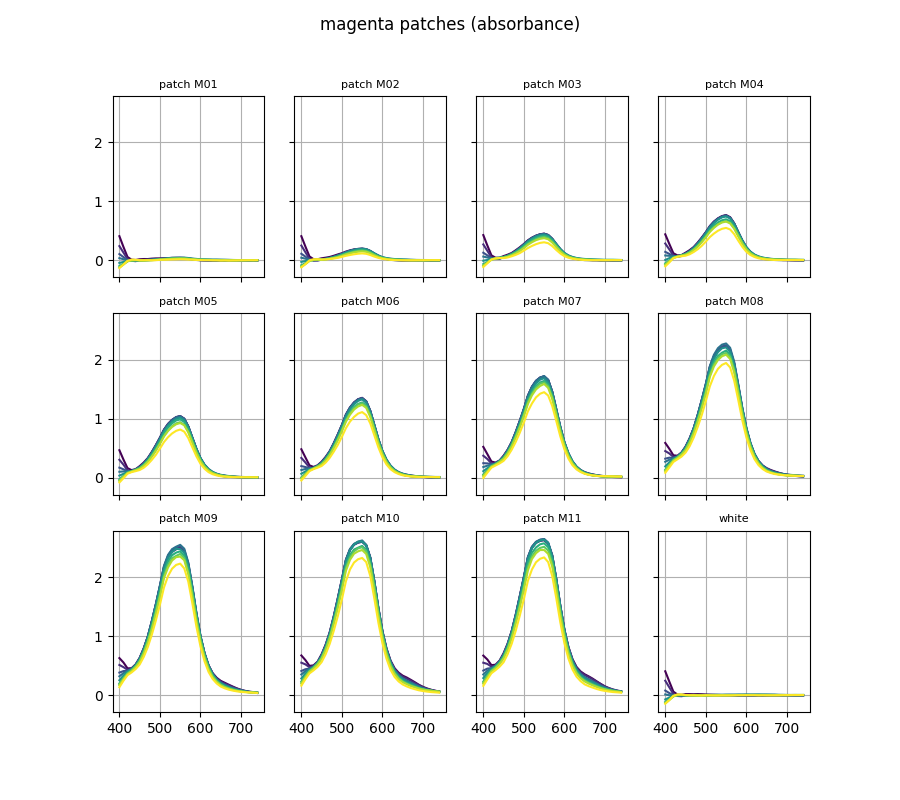

<IPython.core.display.Javascript object>


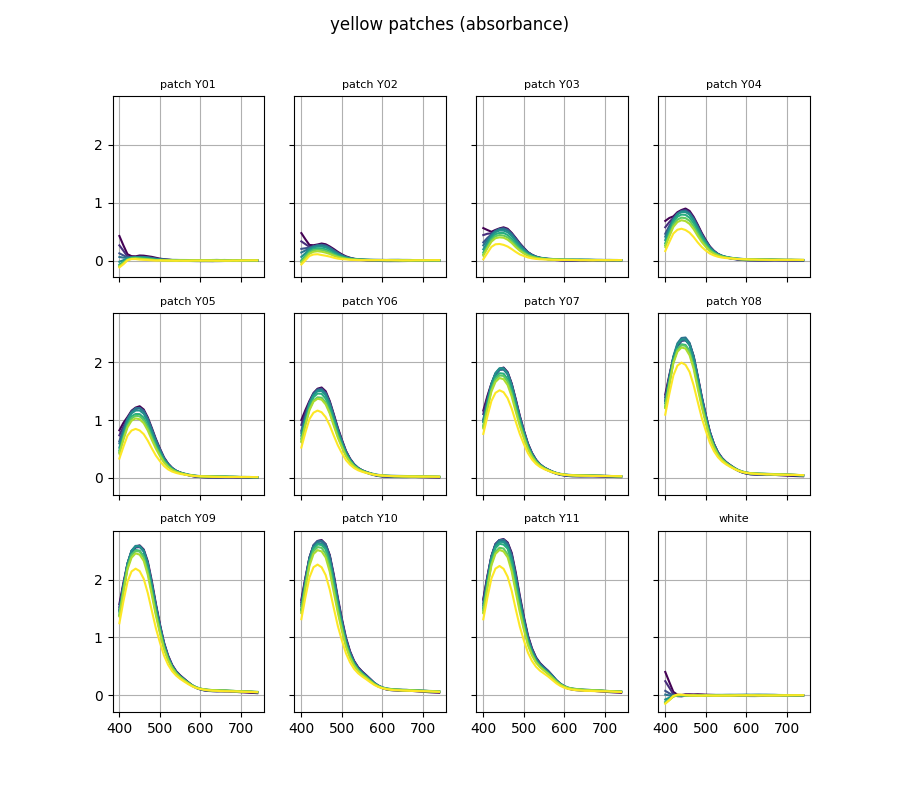

In [ ]:
patches_plot('cyan', absorbance=True)
patches_plot('magenta', absorbance=True)
patches_plot('yellow', absorbance=True)

We need to divide by the white spectrum in order to get the transmission... 

In [ ]:
wavelengths_gt400, absorbance_spectra = absorbance_spectra()

In [ ]:
exposure = sorted(list(set(cum_hrs)))

In [ ]:
exposure

[0, 3, 22, 45, 90, 157, 201, 245, 392]

In [ ]:
is_hue = hues == 'yellow'

In [ ]:
patches;

In [ ]:
patches[is_hue]

array(['Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09',
       'Y10', 'Y11', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07',
       'Y08', 'Y09', 'Y10', 'Y11', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05',
       'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y01', 'Y02', 'Y03',
       'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y01',
       'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10',
       'Y11', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08',
       'Y09', 'Y10', 'Y11', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06',
       'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y01', 'Y02', 'Y03', 'Y04',
       'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y01', 'Y02',
       'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11'],
      dtype=object)

In [ ]:
patchset = sorted(list(set(patches[is_hue])))

In [ ]:
def get_trajectories(hue, patches=patches, exposure=exposure): 
    '''Returns a sorted array of trajectories'''

    is_hue = hues == hue

    patchset = sorted(list(set(patches[is_hue])))
    patch_series = []

    for i, p in enumerate(patchset): 

        indices = patches == p

        patch_spectra = absorbance_spectra[indices]
        patch_series.append(patch_spectra)

    patch_series = np.array(patch_series)


    max_index = np.argwhere(patch_series == patch_series.max()).flatten()[-1]

    trajectories = patch_series[:,:, max_index] 
    
    indices = np.argsort(np.max(trajectories, axis=1))[::-1]

    exposure = np.array(exposure)

    trajectories = trajectories[indices]
    patchset = np.array(patchset)[indices]

    return patchset, trajectories 

In [ ]:
get_trajectories('yellow')

(array(['Y11', 'Y10', 'Y09', 'Y08', 'Y07', 'Y06', 'Y05', 'Y04', 'Y03',
        'Y02', 'Y01'], dtype='<U3'),
 array([[2.70052887, 2.6873924 , 2.6873924 , 2.68902505, 2.65055877,
         2.60446766, 2.53627591, 2.48568413, 2.18607348],
        [2.68413506, 2.66162608, 2.67281724, 2.66481079, 2.61959654,
         2.59698819, 2.54897898, 2.48701835, 2.21311569],
        [2.59104464, 2.56328537, 2.5748797 , 2.58219503, 2.57342304,
         2.49910715, 2.48568413, 2.43119594, 2.14730894],
        [2.39645299, 2.38072369, 2.37832561, 2.42615815, 2.3915868 ,
         2.29671803, 2.28247121, 2.23570392, 1.95427187],
        [1.90682609, 1.90086482, 1.87447033, 1.87736888, 1.8942006 ,
         1.80191411, 1.76297814, 1.70635925, 1.48113835],
        [1.56248399, 1.54776237, 1.53222607, 1.52914756, 1.50285687,
         1.45321164, 1.38618334, 1.35342217, 1.13467158],
        [1.23865183, 1.20883268, 1.21106648, 1.20883268, 1.16624207,
         1.10239427, 1.06434442, 1.0129063 , 0.8204962 ],
   

In [ ]:
def trajectory_plot(hue): 
    
    patchset, trajectories = get_trajectories(hue)

    fig, ax = plt.subplots(figsize=[9, 5]) 
    
    # yellow markers have too low contrast 
    if hue is 'yellow': 
        color = 'orange'
    else: 
        color = hue

    for patch, traject in zip(patchset, trajectories): 

        ax.scatter(exposure, traject, c=color, marker='s')
        ax.plot(exposure, traject, alpha=0.5)
        ax.annotate(patch, [exposure[0], traject[0]], fontsize=8, ha='center', va='bottom')
        ax.grid()
        
    ax.set_title(hue)


<IPython.core.display.Javascript object>


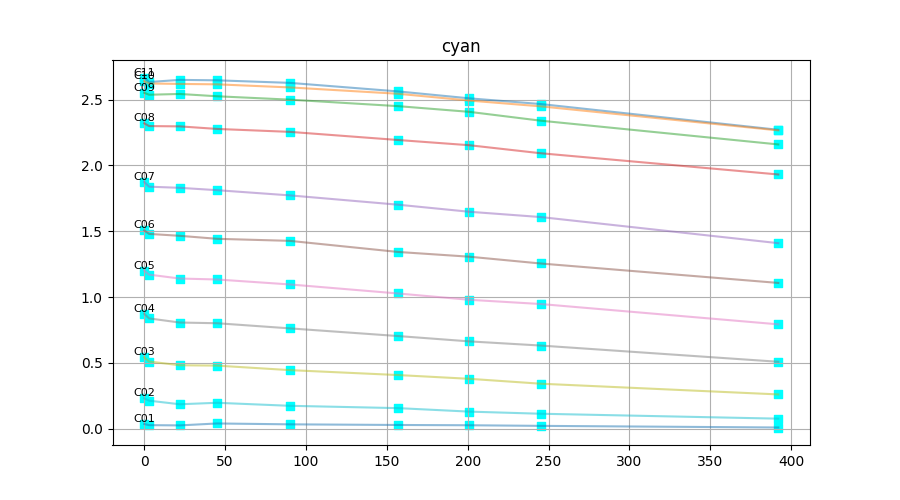

<IPython.core.display.Javascript object>


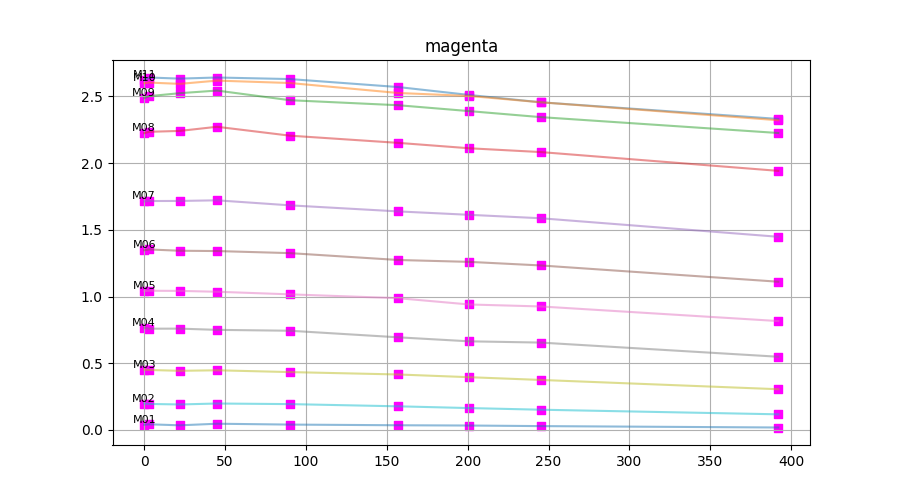

<IPython.core.display.Javascript object>


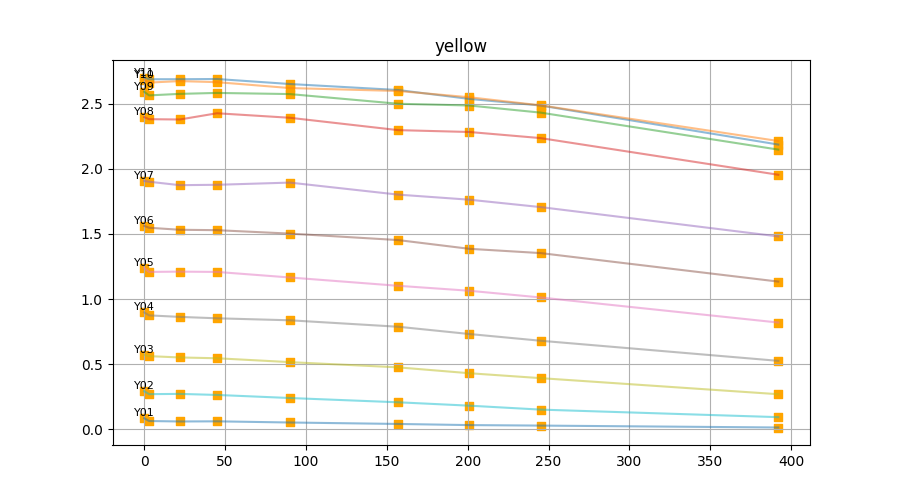

In [ ]:
trajectory_plot('cyan')
trajectory_plot('magenta')
trajectory_plot('yellow')

For high densities, we see crossing trajectories. This can not be explained with dye fading. For now, let's simply skip any crossing trajectories... 

We need a time shift algorithm... 

In [ ]:
hue_patches, hue_trajectories = get_trajectories('yellow')

In [ ]:
#def timeshift(trajectories, exposure): 

In [ ]:
# initialize with maximum density patch trajectory 

traject_0 = hue_trajectories[0]
timeshifted = [np.array([exposure, traject_0])]  

# calculate time shift and append  

In [ ]:
for i, traject in enumerate(hue_trajectories[1:]): 
    
    # first check if current trajectory is non-crossing with previous 
    
    if np.any(timeshifted[-1][1] - traject < 0): 
        print(f'{i} {hue_patches[i]}: x')
        
        
         
    else: 
        print(f'{i} {hue_patches[i]}: -')
    
    
    
    
    
    
    
    

0 Y11: x
1 Y10: -
2 Y09: -
3 Y08: -
4 Y07: -
5 Y06: -
6 Y05: -
7 Y04: -
8 Y03: -
9 Y02: -


In [ ]:
import scipy.interpolate as sip 

def interpolate(x, y): 
    
    

In [ ]:
traject_0 - timeshifted[0][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
traject_max = 

['Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11']

In [ ]:
trajectories[10]

array([2.70052887, 2.6873924 , 2.6873924 , 2.68902505, 2.65055877,
       2.60446766, 2.53627591, 2.48568413, 2.18607348])

In [ ]:
y_10 = trajectories[10]
y_09 = trajectories[9]

In [ ]:
x = exposure

In [ ]:
import scipy.interpolate as sip

In [ ]:
ipol_10 = sip.interp1d(x, y_10, kind='linear')
ipol_09 = sip.interp1d(x, y_09, kind='linear')

In [ ]:
xx = np.linspace(exposure[0], exposure[-1], 1000) 

<IPython.core.display.Javascript object>


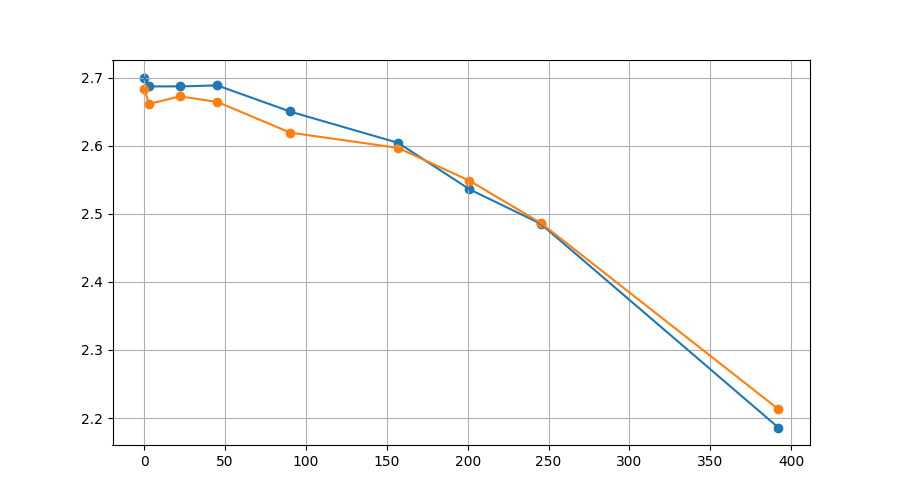

In [ ]:
fig, ax = plt.subplots(figsize=[9, 5])

ax.plot(xx, ipol_10(xx))
ax.plot(xx, ipol_09(xx))
ax.scatter(x, y_10)
ax.scatter(x, y_09)
ax.grid()